In [1]:
import warnings
import numba


warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=numba.NumbaDeprecationWarning)


import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from creating import create_trajectories
from utils import gen_dist_matrix, circle_metric, normalize_angle, circle_metric_without_grad, OrderScore, plot_scores, plot_score_diffs, plot_all_2d, get_stop_point, plot_1d
import umap
from functools import partial
from tqdm import trange

Hypreparameters

In [2]:
n_epochs_1d = 10000
n_neighbors_frac = 0.5
max_dim = 6
n_reference = 40
n_nearest_frac = 0.25
threshold = 0.01


The algorithm starts with loading the data points from trajectories and normalazing it such that along each coordinate the data has zero mean and unit variance

showing 3 trajectories in the data
raw data


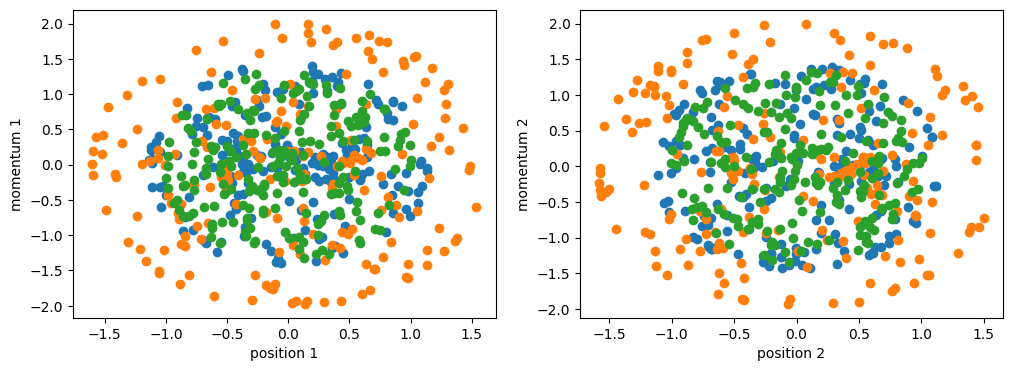

normalized data


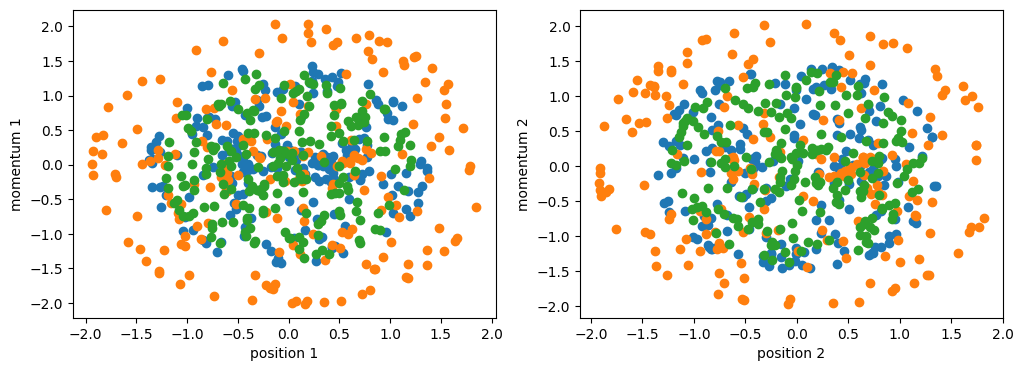

In [4]:
N_plotted = 3


def plot_co(data):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    for i in [0, 1]:
        for traj in data[:N_plotted]:
            ax[i].scatter(*traj[:, [i, 2 + i]].T)
        ax[i].set_xlabel(f"position {i + 1}")
        ax[i].set_ylabel(f"momentum {i + 1}")
    plt.show()


coupled_oscillator = np.load("data/coupled_oscillator.npz")
data_co = coupled_oscillator["data"] # data_co is a np.ndarray of shape (n_trajectories, trajectory_length, state_length)
params_co = coupled_oscillator["params"] # conserved quantities computed theoretically

print(f"showing {N_plotted} trajectories in the data")
print("raw data")

plot_co(data_co)


data_co = StandardScaler().fit_transform(np.concatenate(list(data_co))).reshape(data_co.shape)

print("normalized data")

plot_co(data_co)

The next step of the algorithm is to compute the Wasserstein distances between trajectories and get a distance matrix

Finished preprocessing 200 events in 0.0016s
   1990 / 19900  EMDs computed  -  10.00% completed - 4.136s
   3980 / 19900  EMDs computed  -  20.00% completed - 8.156s
   5970 / 19900  EMDs computed  -  30.00% completed - 11.765s
   7960 / 19900  EMDs computed  -  40.00% completed - 15.130s
   9950 / 19900  EMDs computed  -  50.00% completed - 18.460s
  11940 / 19900  EMDs computed  -  60.00% completed - 21.863s
  13930 / 19900  EMDs computed  -  70.00% completed - 25.282s
  15920 / 19900  EMDs computed  -  80.00% completed - 28.756s
  17910 / 19900  EMDs computed  -  90.00% completed - 31.924s
  19900 / 19900  EMDs computed  - 100.00% completed - 35.124s


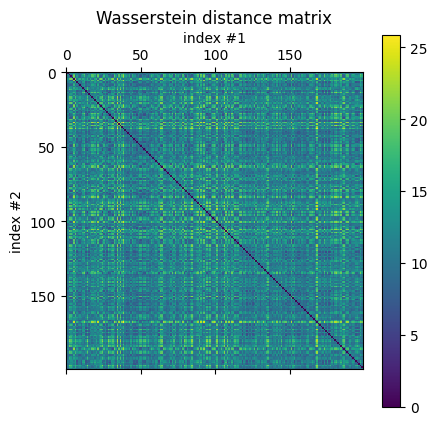

In [5]:
dmat_co = gen_dist_matrix(data_co)


plt.matshow(dmat_co)
plt.title("Wasserstein distance matrix")
plt.gca().xaxis.set_label_position('top') 
plt.xlabel("index #1")
plt.ylabel("index #2")
plt.colorbar()


Using the Wasserstein distance matrix we can compute a sequence of UMAP embeddings

In [6]:
embeddings = []


UMAP = partial(umap.UMAP, n_neighbors=int(n_neighbors_frac * len(dmat_co)), metric="precomputed")

periodic_embedding = UMAP(n_components=1,
                          output_metric=circle_metric,
                          n_epochs=n_epochs_1d).fit_transform(dmat_co)
periodic_embedding = np.vectorize(normalize_angle)(periodic_embedding)
embeddings.append(periodic_embedding)

for n_components in trange(1, max_dim + 1):
    if n_components == 1:
        embedding = UMAP(n_components=n_components, n_epochs=n_epochs_1d).fit_transform(dmat_co)
    else:
        embedding = UMAP(n_components=n_components).fit_transform(dmat_co)
    embeddings.append(embedding)

100%|██████████| 6/6 [00:40<00:00,  6.69s/it]


For each embedding we compute the score measuring how much the metric stricture in the embedding deviates from the metric structure given by the Wasserstein distance

In [7]:
order_score = OrderScore(dmat_co, n_reference, int(n_nearest_frac * len(dmat_co)))

scores = []
errors = []

score, error = order_score.order_score(embeddings[0], output_metric=circle_metric_without_grad)
scores.append(score)
errors.append(error)

for embedding in embeddings[1:]:
    score, error = order_score.order_score(embedding)
    scores.append(score)
    errors.append(error)

Now we can take a look on the scores and score differences to understand the results.

2


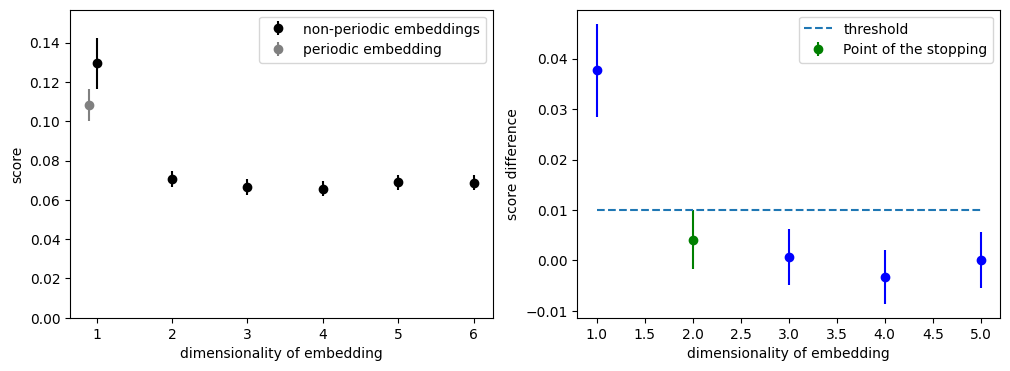

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

predicted_n_conserved = get_stop_point(scores, threshold)
print(predicted_n_conserved)

plot_scores(ax1, scores, errors)
plot_score_diffs(ax2, scores, errors, predicted_n_conserved, threshold)

The first time the score difference is lower than the threshold is between the second and third score. This means that the algorithm predicts two conserved quantities in the system.

We can check that the UMAP was not able to embedtrajectories with similar energies into neighboring points in 1d, but it was able to do so in 2d

1d embedding


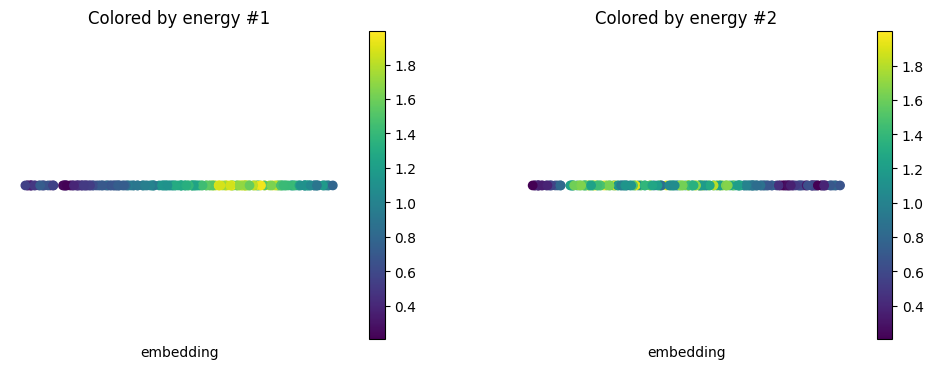

2d embedding


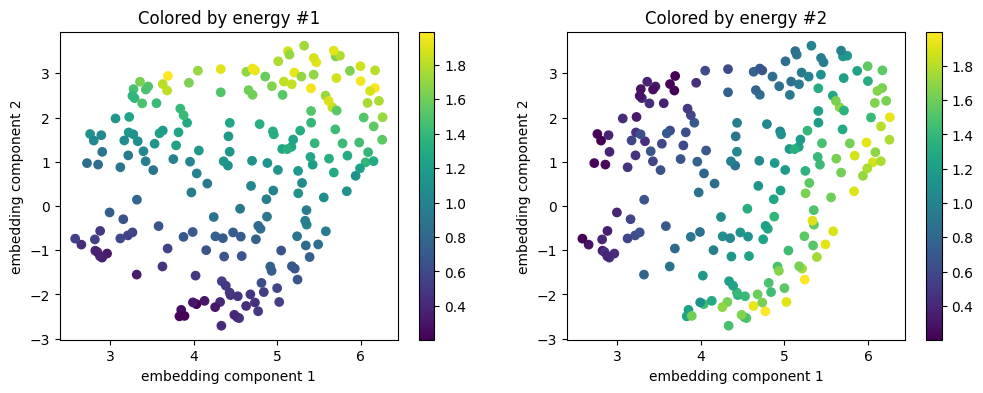

In [9]:
print("1d embedding")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plot_1d(fig, ax1, embeddings[1], params_co[:, 0], "energy #1")
plot_1d(fig, ax2, embeddings[1], params_co[:, 1], "energy #2")

plt.show()


print("2d embedding")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plot_all_2d(fig, ax, embeddings[2], params_co, ["energy #1", "energy #2"])

plt.show()